In [1]:
import os
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

%matplotlib notebook 

In [2]:
n_channels = 4
data_dir = os.path.join(os.pardir, 'data')
files = ['data_sintel_pierre_2.csv', 'data_sintel_pierre_3.csv']
dfs = [pd.read_csv(os.path.join(data_dir, f)) for f in files]

In [3]:
dfs[0].head()

,timestamps,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Marker
0,1.490137e+09,-102.499,112.616,106.243,-212.871,0
1,1.490137e+09,-46.687,172.785,201.362,219.310,0
2,1.490137e+09,-120.337,84.112,136.718,94.606,0
3,1.490137e+09,-141.905,58.722,82.227,-265.258,0
4,1.490137e+09,-24.018,179.265,162.484,93.146,0


In [4]:
dfs[1].head()

,timestamps,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Marker
0,1.490137e+09,-194.978,7.568,70.596,-247.589,0
1,1.490137e+09,-88.636,127.332,198.929,57.940,0
2,1.490137e+09,-113.581,79.664,206.347,223.751,0
3,1.490137e+09,-214.536,0.449,95.066,-184.687,0
4,1.490137e+09,-119.780,88.942,147.201,-107.894,0


# Helper functions

In [5]:
def plot_trials(dfs, n_channels):
    """
    Plot EEG channel data for all trials.

    :param dfs: (list) 
        EEG data of the trials. Assumes one pd.DataFrame per trial.
    :param n_channels: (int) 
        Number of channels to plot. Assumes channel indexing starts at 1.
    """
    n_trials = len(dfs)
    f, ax = plt.subplots(ncols=n_trials, nrows=n_channels, sharex=True, 
                         sharey=True, figsize=(8,8))
    for nt in range(n_trials):
        for nc in range(n_channels):
            channel_ix = nc+1
            data = dfs[nt].iloc[:, channel_ix].values
            t = range(len(data))
            l, = ax[nc][nt].plot(t, data, label='channel %s' % channel_ix)
            # ax[nc][nt].legend(handles=[l], loc=1)
            ax[nc][nt].set_title('Trial #%s | Channel #%s' % (nt, channel_ix))
            ax[nc][nt].set_xlim(t[0], t[-1])

    # Legends only where necessary (x and y axis are shared)
    for nc in range(n_channels):
            ax[nc][0].set_ylabel('eeg')
    for nt in range(n_trials):
            ax[-1][nt].set_xlabel('time')
    plt.tight_layout()

In [6]:
def reshape_trials(dfs, n_channels):
    """
    Reshape EEG data. Clip to start (Marker=1) and end (Marker=2) 
    and truncate all trials to same lenght.
    
    :param dfs: (list) 
        EEG data of the trials. Assumes one pd.DataFrame per trial.
    :param n_channels: (int) 
        Number of channels to plot. Assumes channel indexing starts at 1.
    """
    # Clip to start and end markers.
    r_dfs = []
    for df in dfs:
        tag = np.array(df.Marker)
        start = np.where(tag == 1)[0][0]
        end = np.where(tag == 2)[0][0]
        r_dfs.append(df.iloc[start:end, :])
        
    # Data may be off by a few samples. Truncate.
    N_samp = min([len(r_df) for r_df in r_dfs])
    print 'Number of samples:', N_samp
    r_dfs = [r_df.iloc[:N_samp, :] for r_df in r_dfs]
    return r_dfs

In [7]:
def bandpass(data, sampling_frequency, start_frequency, end_frequency):
    """
    Butterworth bandpass filter.
    
    :param data: (np.array)
        Input data to filter.
    :param sampling_frequency: (float)
        Sampling frequency of the input signal to filter.
    :param start_frequency: (float)
        Start of the filter frequency band.
    :param stop_frequency: (float)
        End of the filter frequency band.
    """
    f_nyquist = sampling_frequency / 2.0
    f_start = start_frequency / f_nyquist
    f_end = end_frequency / f_nyquist
    a, b = signal.butter(2, [f_start, f_end], 'bandpass')
    return signal.filtfilt(a, b, data, axis=0)


def filter_trials(dfs, n_channels, sampling_frequency, start_frequency, 
                  stop_frequency):
    """
    Filter signals to remove noise.
    
    :param dfs: (list) 
        EEG data of the trials. Assumes one pd.DataFrame per trial.
    :param n_channels: (int) 
        Number of channels to plot. Assumes channel indexing starts at 1.
    :param sampling_frequency: (float)
        Sampling frequency of the input signal to filter.
    :param start_frequency: (float)
        Start of the filter frequency band.
    :param stop_frequency: (float)
        End of the filter frequency band.
    """
    f_dfs = []
    for df in dfs:
        filt = lambda x: bandpass(x, sampling_frequency, start_frequency, stop_frequency)
        f_df = df.apply(filt)
        f_dfs.append(f_df)
    return f_dfs

# Data cleaning

<IPython.core.display.Javascript object>


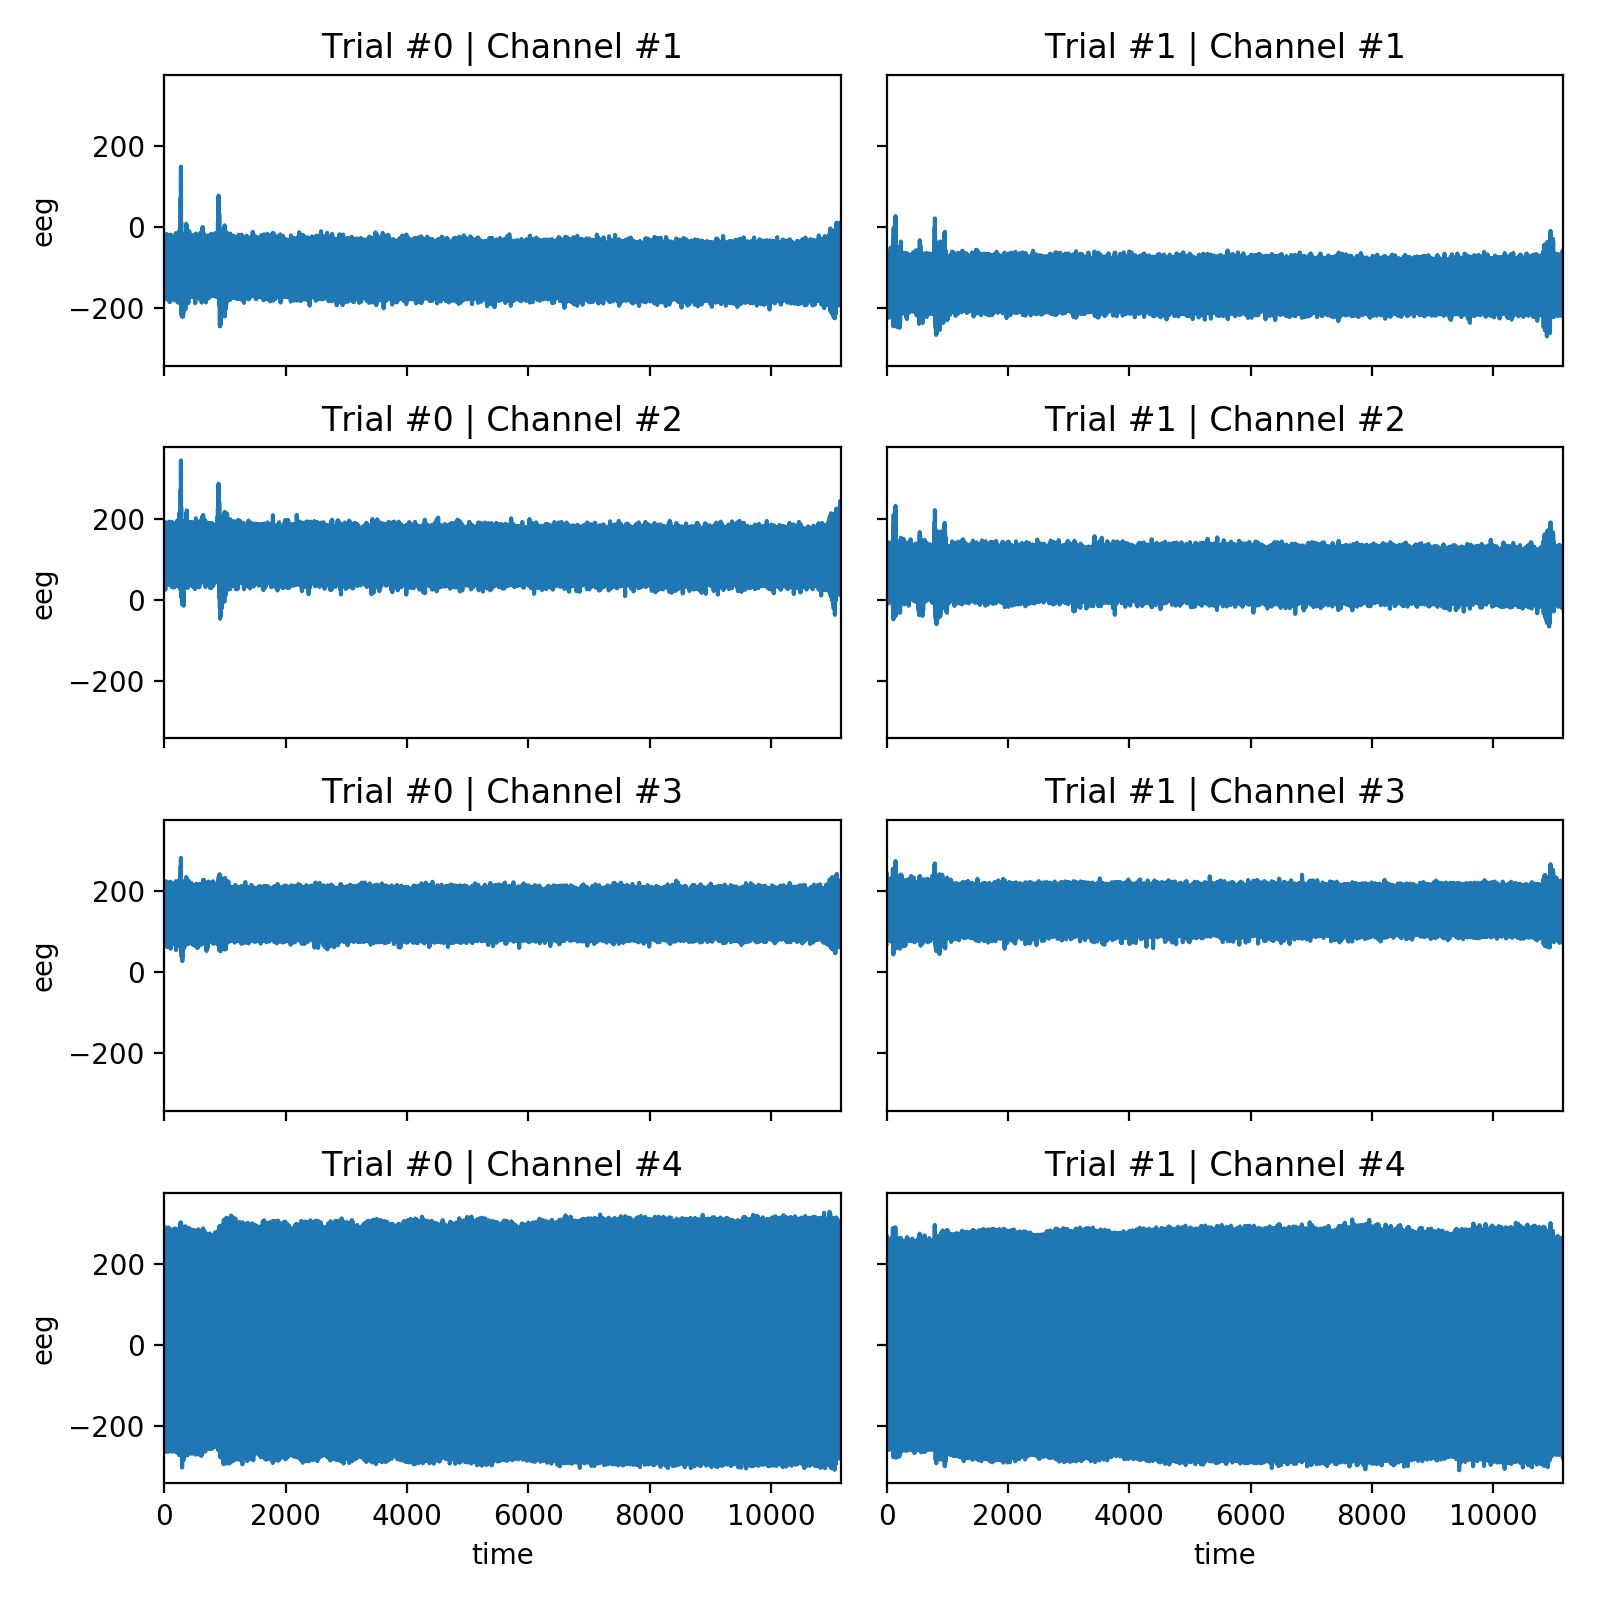

In [8]:
plot_trials(dfs, n_channels)

In [9]:
r_dfs = reshape_trials(dfs, n_channels)
print 'Reshaped length of trial #0:', len(r_dfs[0])

Number of samples: 10531
Reshaped length of trial #0: 10531


<IPython.core.display.Javascript object>


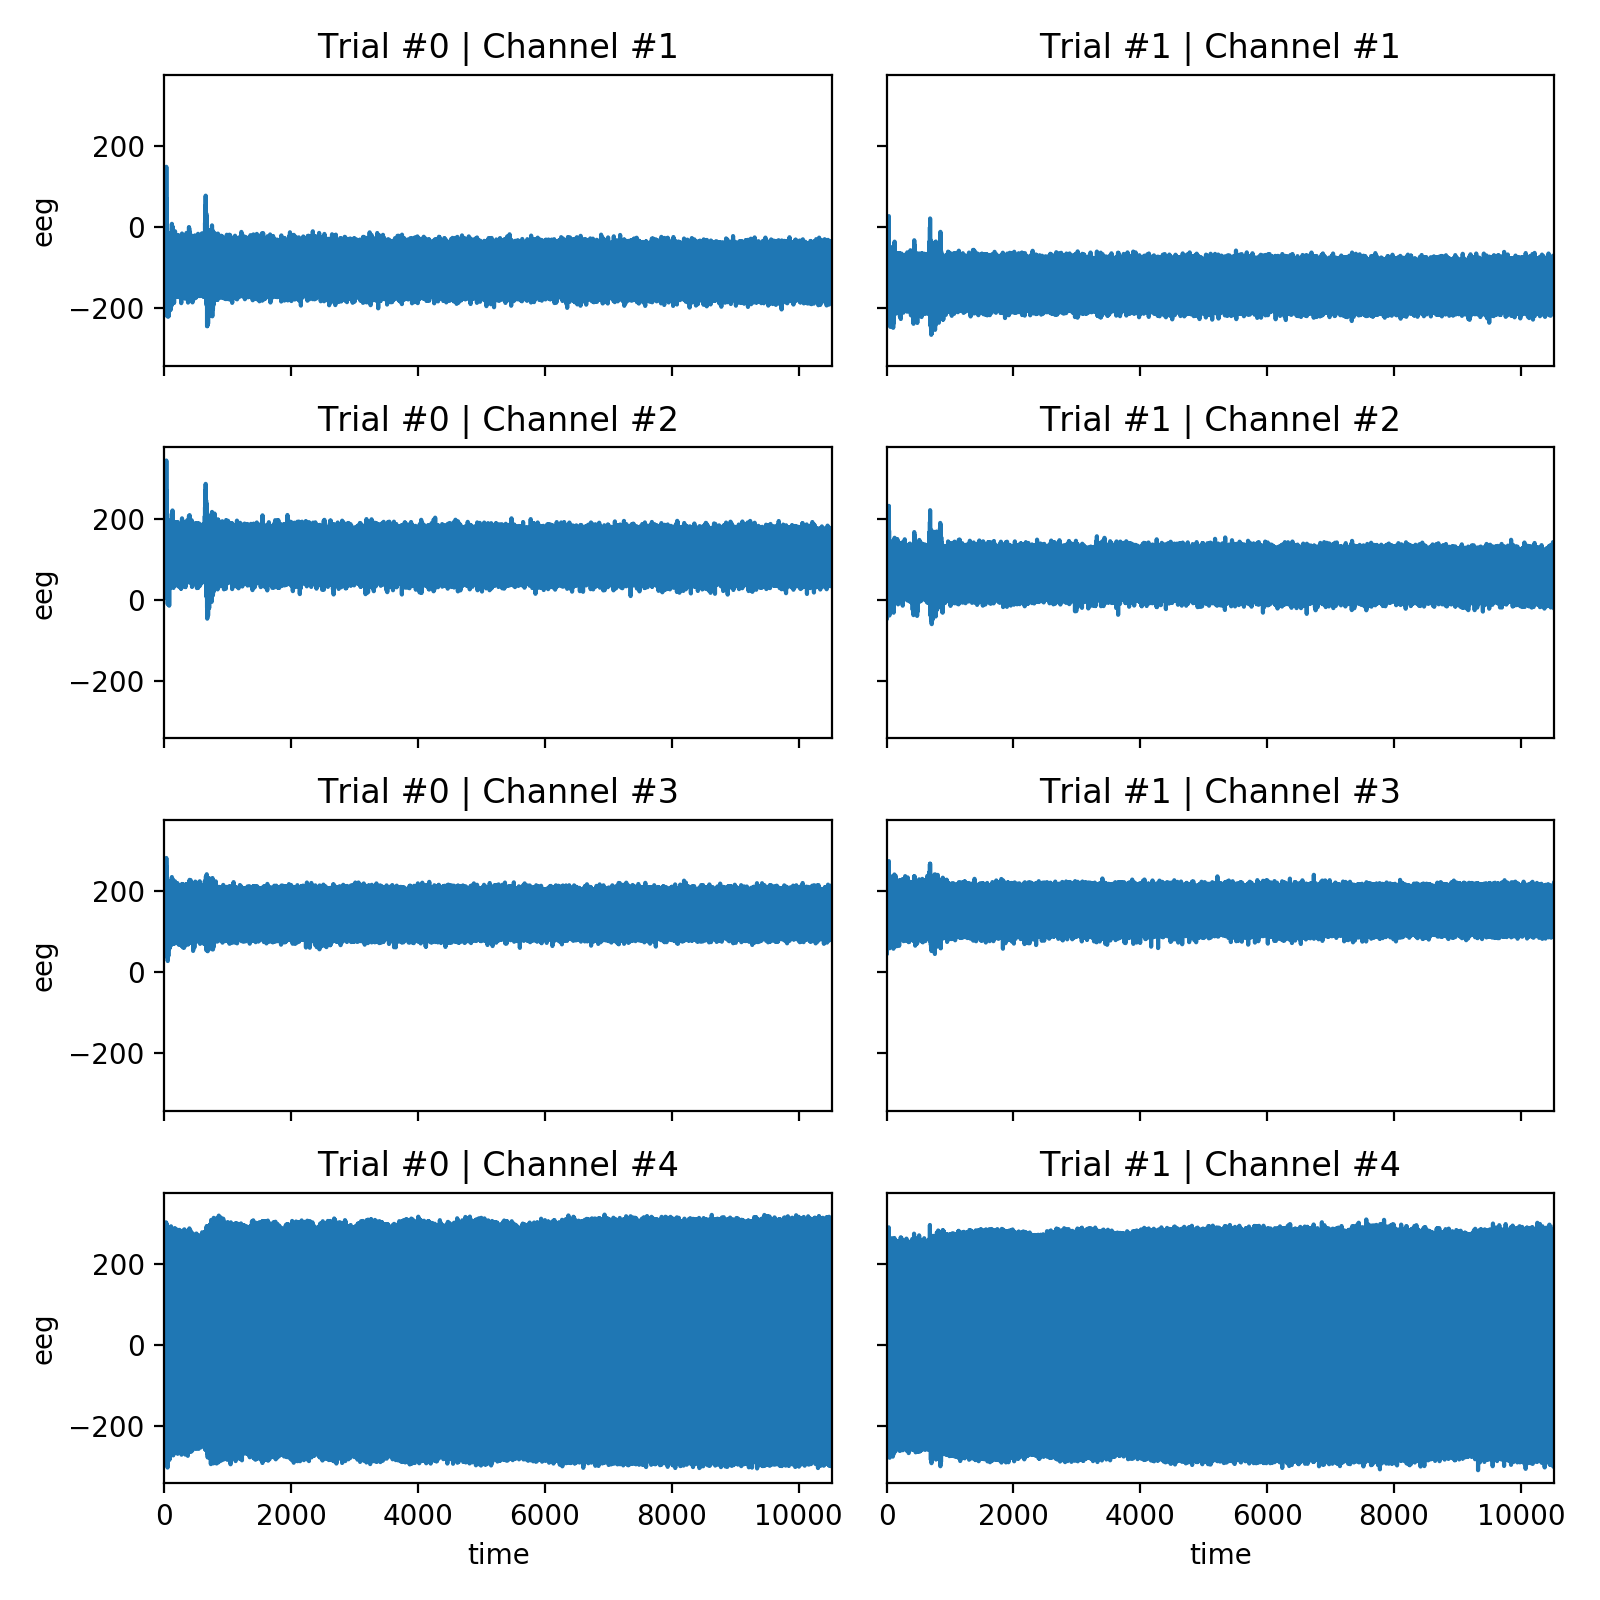

In [10]:
plot_trials(r_dfs, n_channels)

In [11]:
start_frequency = 1.0
stop_frequency = 15.0
sampling_frequency = 200.0 # sampling rate of ganglion is 200Hz

f_dfs = filter_trials(r_dfs, n_channels, sampling_frequency, 
                      start_frequency, stop_frequency)

<IPython.core.display.Javascript object>


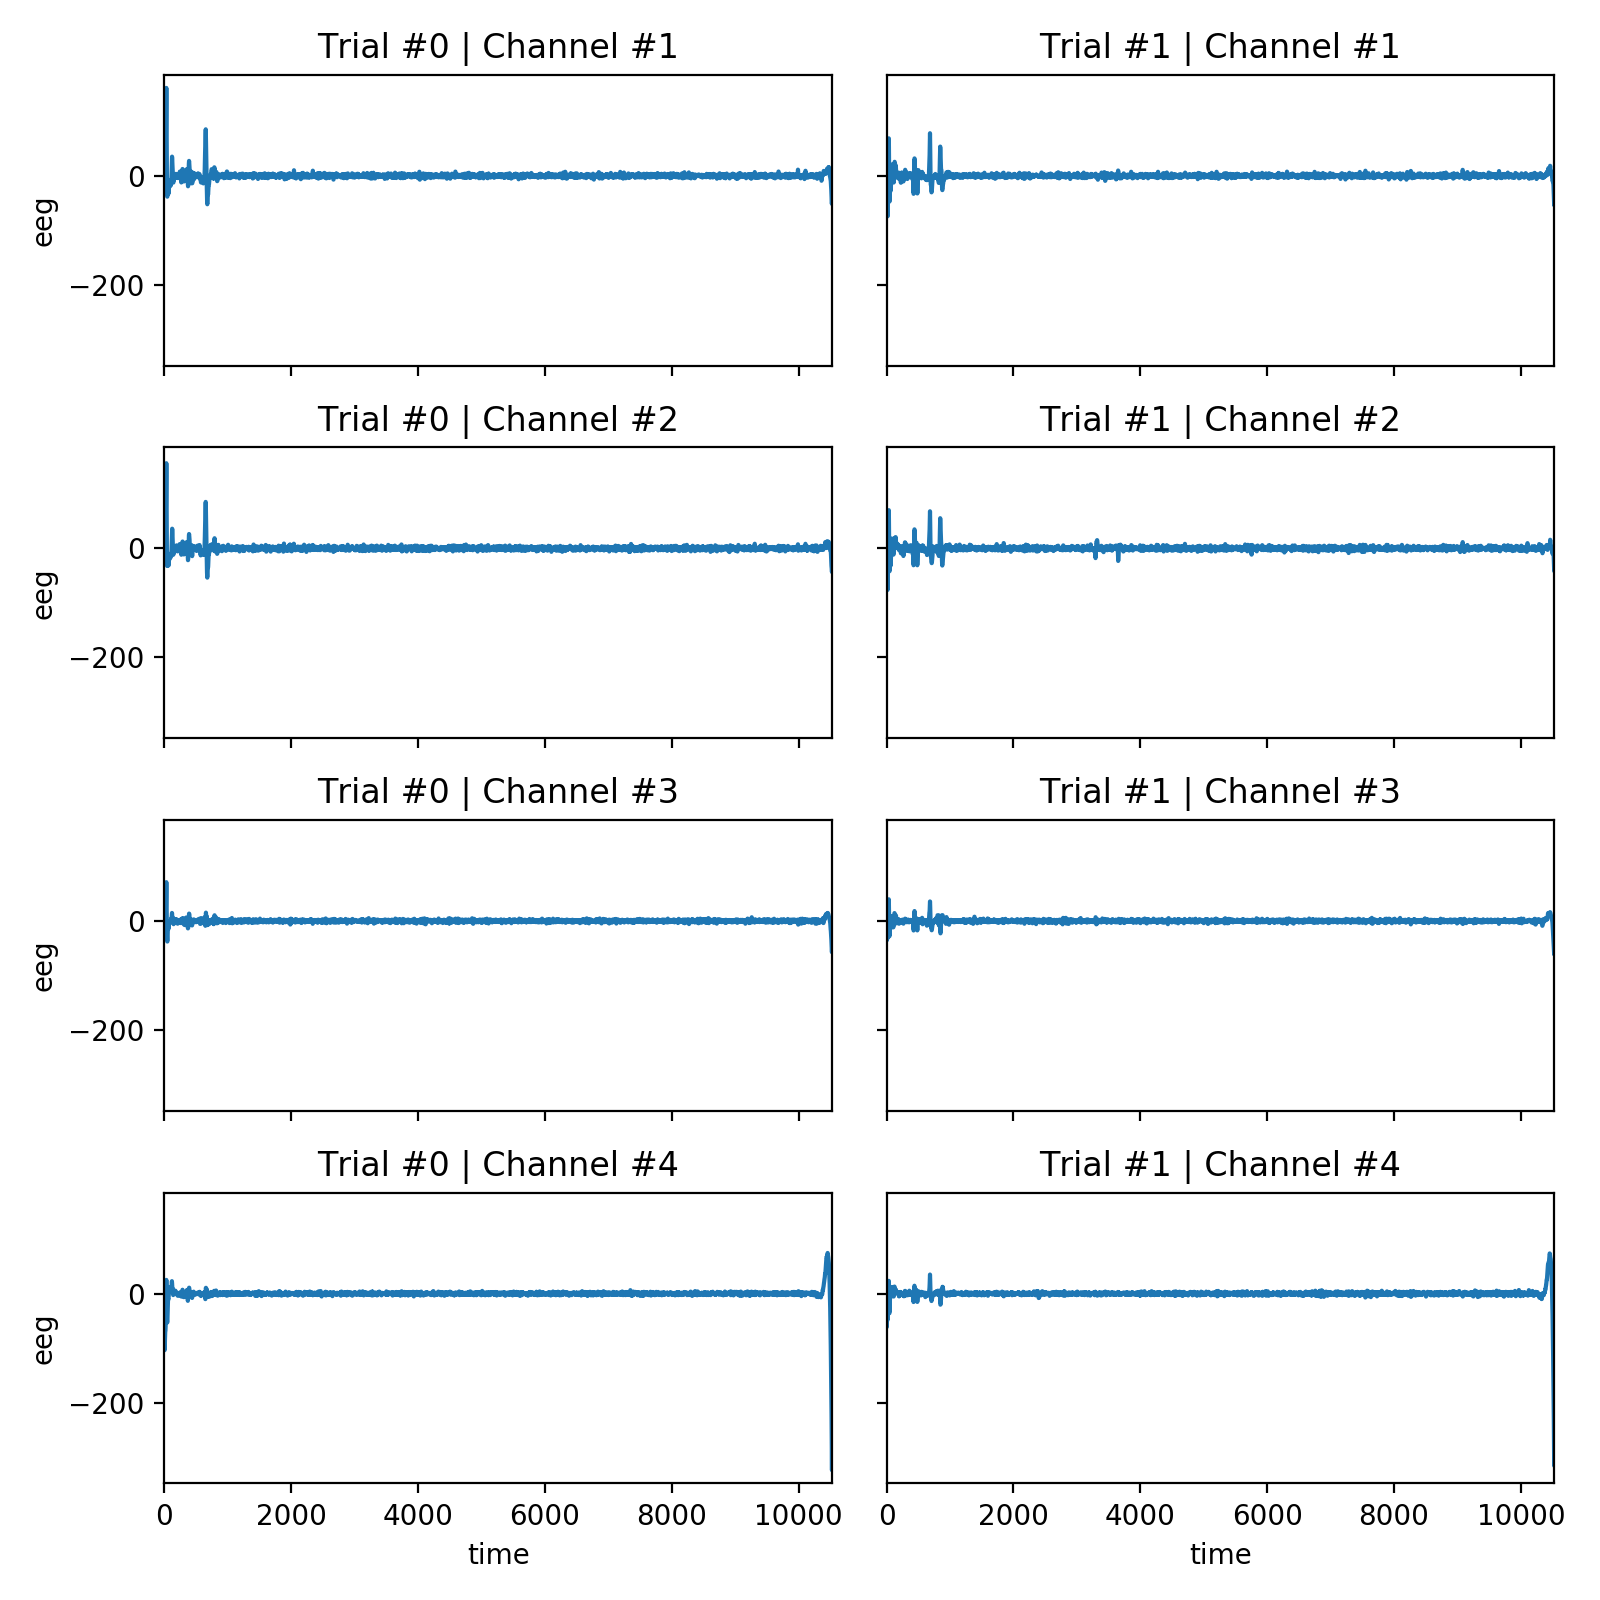

In [12]:
plot_trials(f_dfs, n_channels)

<IPython.core.display.Javascript object>


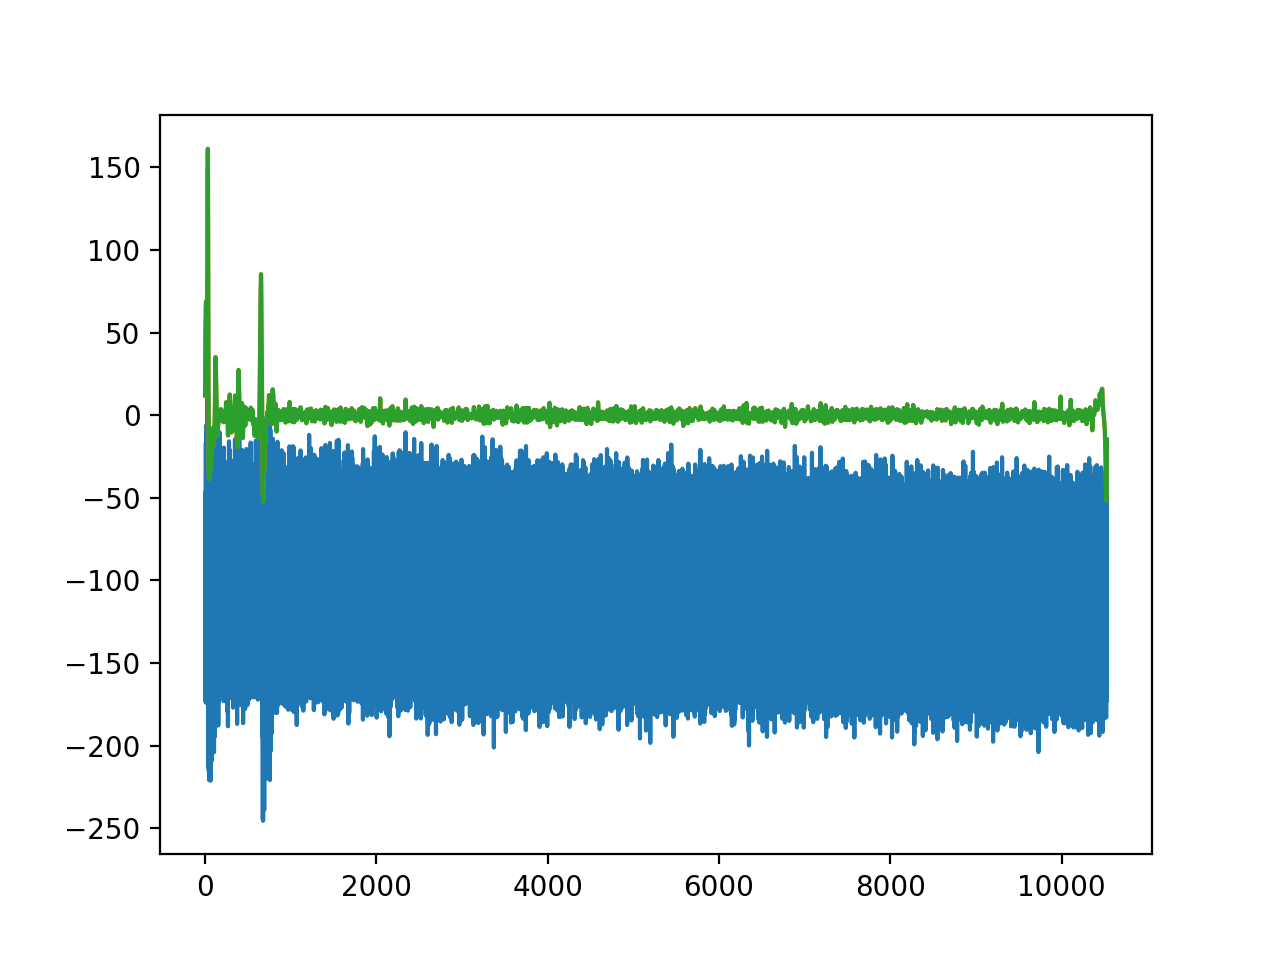

In [13]:
# Compare PK and MLB techniques
eeg = r_dfs[0].iloc[:, 1].values

# filter signal to remove noise
fs = 200.0
b, a = signal.butter(2, (2/fs, 30/fs), btype='bandpass')
pk_f_eeg = signal.filtfilt(b, a, eeg, axis=0)
mlb_f_eeg = f_dfs[0].iloc[:, 1].values

plt.figure()
plt.plot(eeg)
plt.plot(pk_f_eeg)
plt.plot(mlb_f_eeg)

# Spectrogram 

<IPython.core.display.Javascript object>


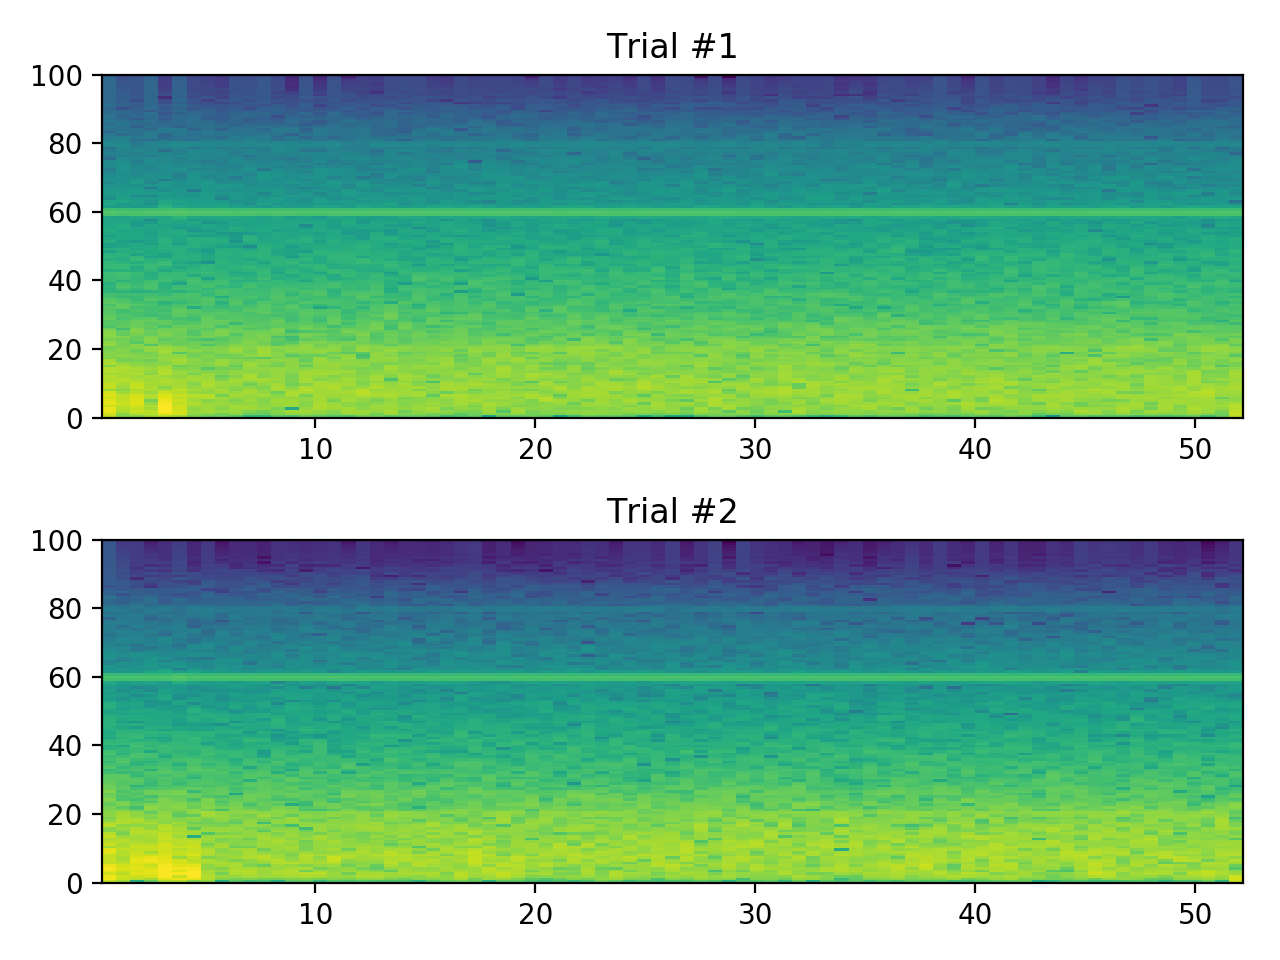

In [19]:
# plt.figure()
# plt.pcolormesh(t, f, Sxx)
# plt.ylabel('Frequency')
# plt.xlabel('Time')
# plt.show()

fs = 200.0
NFFT = 256 #1024       # the length of the windowing segments
Fs = 200.0  # the sampling frequency
noverlap = 128 #900
# spectrum : 2-D array
# Columns are the periodograms of successive segments.
# freqs : 1-D array
# The frequencies corresponding to the rows in spectrum.
# t : 1-D array
# The times corresponding to midpoints of segments (i.e., the columns in spectrum).
# im : instance of class AxesImage
# The image created by imshow containing the spectrogram

x1 = f_dfs[0].iloc[:, 1].values
x2 = f_dfs[1].iloc[:, 1].values

f, ax = plt.subplots(2)
spectrum1, freqs1, t1, im1 = ax[0].specgram(x1, NFFT=NFFT, Fs=Fs, noverlap=noverlap)
spectrum2, freqs2, t2, im2 = ax[1].specgram(x2, NFFT=NFFT, Fs=Fs, noverlap=noverlap)
ax[0].set_title('Trial #1')
ax[1].set_title('Trial #2')
plt.tight_layout()

avg_d: 565.231504892


<IPython.core.display.Javascript object>


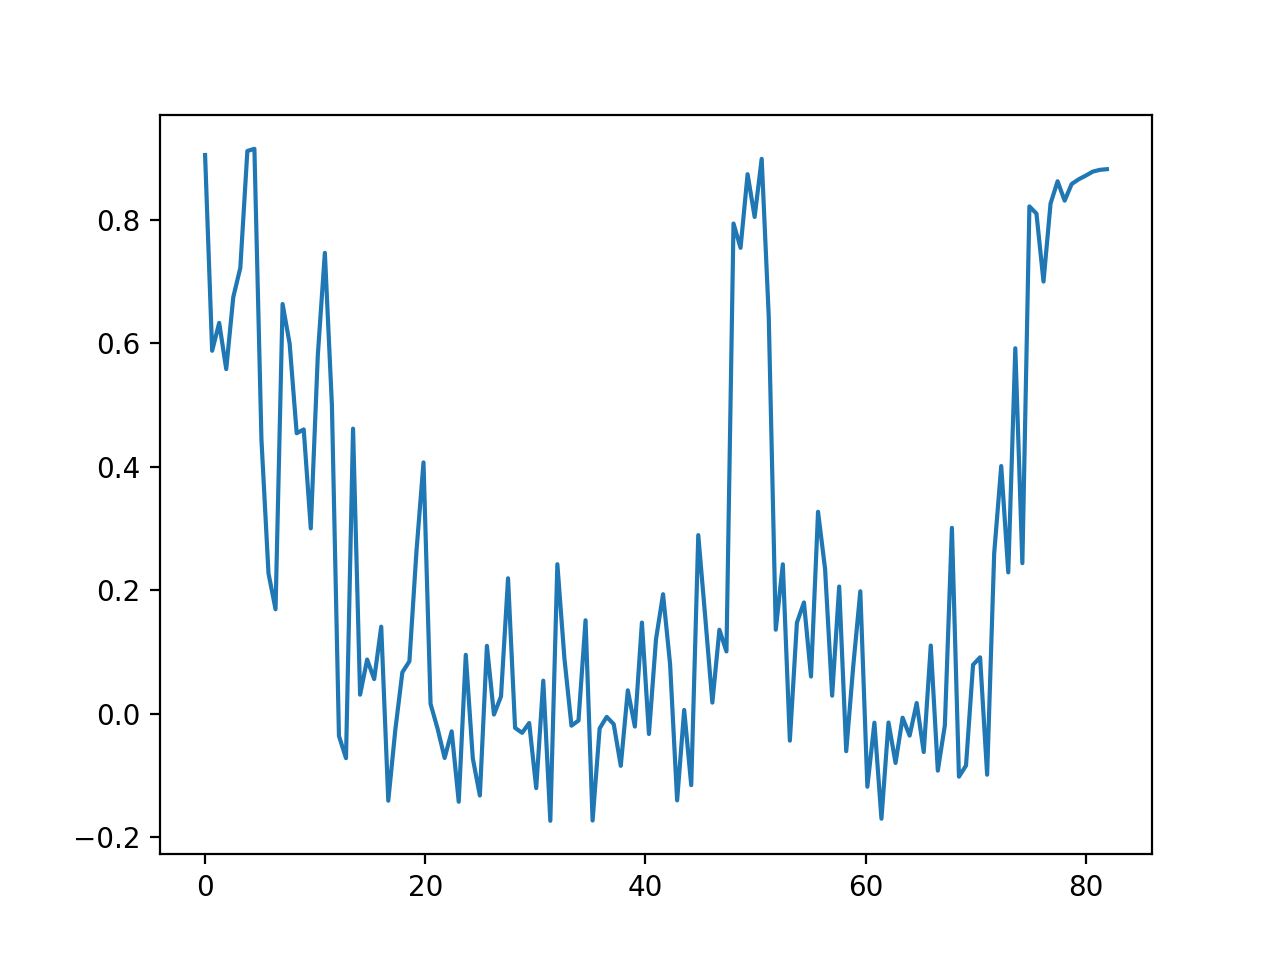

In [27]:
from scipy import stats

step = noverlap / fs
t = np.arange(0, len(freqs1) * step, step)


cutoff_freq = 50.0
freq_idx = np.where(freqs1<cutoff_freq)[0]
dists = []
for i in range(len(freqs1)):
    a = spectrum1[i][freq_idx]
    b = spectrum2[i][freq_idx]
    #d = np.linalg.norm(a-b)
    d = stats.pearsonr(a,b)[0]
    dists.append(d)

avg_d = np.linalg.norm(spectrum1-spectrum2)
print 'avg_d:', avg_d
plt.figure()
plt.plot(t, dists)